<a href="https://colab.research.google.com/github/nilesh0109/RL-assignments/blob/master/Easy21_task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, rc

In [0]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}

rc('font', **font)

# Environment

In [0]:
class human:
  def __init__(self, name):
    self.name=name
    self.black_cards = []
    self.red_cards = []
    
class state:
  def __init__(self, d_card, p_cards):
    self.d_card = d_card.black_cards[0]
    self.p_sum = int(np.sum(p_cards.black_cards) - np.sum(p_cards.red_cards))
    if self.p_sum > 21:
      self.p_sum = 22
    elif self.p_sum < 1:
      self.p_sum = 0
        

In [0]:
class Easy21:
  def start(self):
    self.dealer = human('dealer')
    self.player = human('player')
    self.draw(self.dealer, 'black')
    self.draw(self.player, 'black')
    self.s = state(self.dealer, self.player)
    self.isGameOver = False
    
  def getScore(self, player):
    return np.sum(player.black_cards) - np.sum(player.red_cards)
  
  def draw(self, drawer, color=None):
    if color=='black':
      drawer.black_cards.append(np.random.randint(1,11))
    else:
      color = np.random.choice(2, p=[1/3, 2/3])
      if color == 0:
        drawer.red_cards.append(np.random.randint(1,11))
      else:
        drawer.black_cards.append(np.random.randint(1,11))
      self.s = state(self.dealer, self.player)
    
  def step(self, a='hit'):
    if a=='hit':
      self.draw(self.player)
    else:
      self.draw(self.dealer)
      dealer_score = self.getScore(self.dealer)
      while(dealer_score > 0 and dealer_score <17):
        #since dealer is drawing here so player is sticking
        self.draw(self.dealer,'stick')
        dealer_score = self.getScore(self.dealer)
      self.isGameOver = True
    r = self.calc_rewards()
    
    return self.s, r
  
  def calc_rewards(self):
    player_score = self.getScore(self.player)
    dealer_score = self.getScore(self.dealer)
    if player_score < 1 or player_score > 21:
      self.isGameOver = True
      return -1
    elif dealer_score < 1 or dealer_score > 21:
      self.isGameOver = True
      return 1
    else:
      if self.isGameOver:
        #to avoid the divide by zero error
        abs_reward = player_score - dealer_score
        normalized_reward = 0 if abs_reward == 0 else abs_reward / np.abs(abs_reward)
        return normalized_reward
      else:
        return 0
    
    

# Agent

In [0]:
class Agent:
  def __init__(self):
    self.label ='player'
    
  def play_Easy21(self):
    self.actions ={0:'hit', 1:'stick'}
    self.value = np.zeros((10, 23,len(self.actions)), dtype=np.float64)
    self.N_sa = np.zeros((10, 23,len(self.actions)), dtype=np.int32)
    self.N_s = np.zeros((10, 23), dtype=np.int32)
    self.N0 = 100
  
  def reset(self):
    self.game = Easy21()
    self.game.start()
    
    
  def Monte_Carlo_Control(self):
    '''Implemeting Monte Carlo control using e-greedy'''
    state = self.game.s
    s = state.d_card -1, state.p_sum
    eps = self.N0/(self.N0 + self.N_s[s])
    p = np.random.random()
    val = self.value[s] 
    if p > eps:
      next_action = np.argmax(val)
    else:
      next_action = np.random.randint(len(self.actions))
    return next_action
 
  def run_episodes(self, num_episodes=100):
    for i in range(num_episodes):
      self.reset()
      self.run_episode()

  def run_episode(self):
    trajectory = []

    while not self.game.isGameOver:
      next_action = self.Monte_Carlo_Control()
      curr_state = self.game.s

      next_s, reward = self.game.step(self.actions[next_action])
      seen_trajectory = (curr_state, next_action, reward)
      trajectory.append(seen_trajectory)
    
      G_t = 0
    for i in np.arange(len(trajectory) - 1, -1, -1):
      state, action_taken, received_r = trajectory[i]
      #accumlating the G(t) through DP from end to first state in trjectory
      G_t += received_r
      s = state.d_card - 1, state.p_sum
      self.N_s[s] += 1
      state_act = *s, action_taken
      self.N_sa[state_act] += 1
      alpha = 1/self.N_sa[state_act]
      temp = alpha * (G_t - self.value[state_act])
      temp = np.nan_to_num(temp)
      self.value[state_act] += temp
      
      
   
  

# Monte Carlo Results

In [0]:
monte_agent = Agent()
monte_agent.play_Easy21()
monte_agent.run_episodes(500000)

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


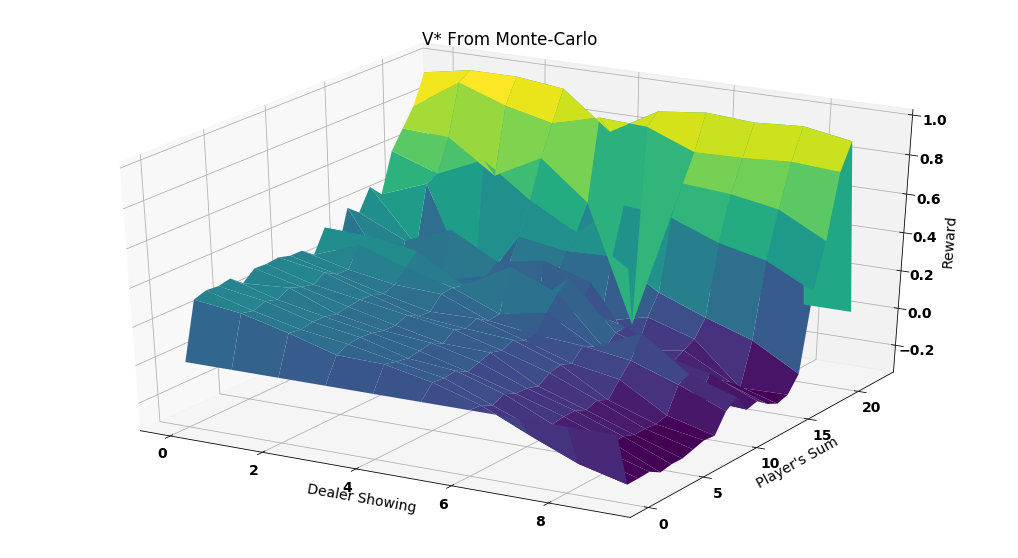

In [18]:
fig,ax = plt.subplots(1,1, figsize=(18,10))
ax = plt.axes(projection='3d')
x,y,z = monte_agent.value.shape
XX,YY = np.meshgrid(np.arange(x), np.arange(y), indexing='ij')
z = np.max(monte_agent.value, axis=2)

ax.set_title('V* From Monte-Carlo')
ax.set_xlabel('Dealer Showing')
ax.set_ylabel("Player's Sum")
ax.set_zlabel('Reward')
ax.plot_surface(XX, YY, z, rstride=1, cstride=1,cmap='viridis', edgecolor='none')

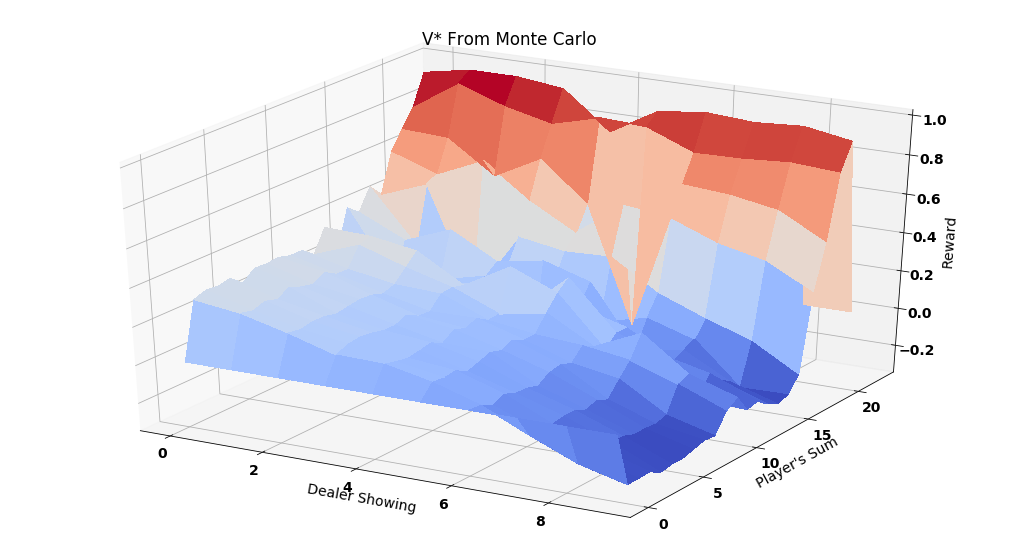

In [19]:
fig,ax = plt.subplots(1,1, figsize=(18,10))
ax = plt.axes(projection='3d')
x,y,z = monte_agent.value.shape
XX,YY = np.meshgrid(np.arange(x), np.arange(y), indexing='ij')
z = np.max(monte_agent.value, axis=2)
ax.set_title('V* From Monte Carlo')
ax.set_xlabel('Dealer Showing')
ax.set_ylabel("Player's Sum")
ax.set_zlabel('Reward')
ax.plot_surface(XX, YY, z, rstride=1, cstride=1, cmap=cm.coolwarm,
                         linewidth=0, antialiased=False)